Notebook for miscellaneous testing.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import emcee
from scipy import optimize, stats
import corner
import sys
sys.path.append('..')
from dev import dataprocessing
import astroabc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
kois = dataprocessing.get_kois()
stellar = dataprocessing.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]

[192950   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

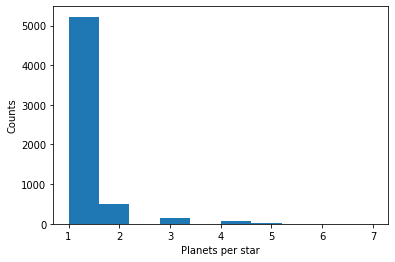

In [11]:
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

In [12]:
# using zeros
# lam = np.mean(solarsyssizes)
lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10) 
print([sum(planet_numbers == i) for i in range(max(planet_numbers))])

[191918, 6858, 140]


(array([1.91918e+05, 0.00000e+00, 0.00000e+00, 6.85800e+03, 0.00000e+00,
        0.00000e+00, 1.40000e+02, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

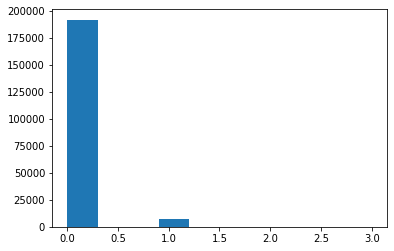

In [13]:
plt.hist(planet_numbers)

In [14]:
from multiprocessing import Pool
p = Pool(2)
def f(x):
    return x * x

%timeit map(f, list(range(int(1e6))))
%timeit p.map(f, list(range(int(1e6))))

Process ForkPoolWorker-1:
Traceback (most recent call last):
Process ForkPoolWorker-2:
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/Cellar/python/3.

54.1 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/p

KeyboardInterrupt: 

In [15]:
kois = dataprocessing.get_kois()
stellar = dataprocessing.get_stellar()
# stellar = dataprocessing.stellar_cuts(stellar)
kois = kois[kois["kepid"].isin(stellar["kepid"])]
period_rng = (50, 300)
rp_rng = (0.75, 2.5)
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
# kois = dataprocessing.kois_cuts(kois, period_rng, rp_rng)

In [16]:
def get_a(period, mstar, Go4pi=2945.4625385377644/(4 * np.pi ** 2)):
    return (Go4pi * period ** 2 * mstar) ** (1./3)

def get_pgeom(aor, e):
    """
    The geometric transit probability.

    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393

    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

In [17]:
combined = kois.merge(stellar, on="kepid")

In [18]:
mstars = stellar.mass
aor = get_a(combined['koi_period'], combined['mass']) / combined['radius']

In [19]:
ecc = kois['koi_eccen']
inc_rad = np.pi * kois['koi_incl'] / 180
omega_rad = np.pi * kois['koi_longp'] / 180
Re_Rs = 0.009168

In [20]:
pgeom = (1) / (aor * (1 - ecc ** 2)) * (aor > 1.0)

In [21]:
pgeom

0       0.126051
1       0.242822
2       0.042001
3       0.024931
4       0.015694
          ...   
7343    0.015857
7344    0.086709
7345    0.134053
7346    0.029849
7347    0.034604
Length: 7348, dtype: float64

In [22]:
kois['koi_longp']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
7343   NaN
7344   NaN
7345   NaN
7346   NaN
7347   NaN
Name: koi_longp, Length: 7348, dtype: float64

In [23]:
np.cos(inc_rad)

0       0.100709
1       0.000873
2       0.020768
3       0.080721
4       0.000873
          ...   
7343    0.010821
7344    0.000873
7345    0.020768
7346    0.020768
7347    0.000873
Name: koi_incl, Length: 7348, dtype: float64